## 1. Import các thư viện cần thiết

In [1]:
# Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Các mô hình hồi quy từ slide
from sklearn.linear_model import LinearRegression, Ridge  # Lecture 3
from sklearn.ensemble import RandomForestRegressor  # Lecture 8
from sklearn.neighbors import KNeighborsRegressor  # Lecture 7
from sklearn.svm import SVR  # Lecture 11
from sklearn.tree import DecisionTreeRegressor  # Lecture 8

## 2. Tải và khám phá dữ liệu

In [2]:
# Tải dữ liệu
print("Đang tải dữ liệu lịch sử Bitcoin...")
df = pd.read_csv('/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv')
print(f"Kích thước dữ liệu: {df.shape}")

Đang tải dữ liệu lịch sử Bitcoin...
Kích thước dữ liệu: (6944800, 7)


In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi timestamp sang dạng datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
print("Thông tin 5 dòng đầu tiên:")
print(df.head())

Thông tin 5 dòng đầu tiên:
                     Open  High   Low  Close  Volume  \
Timestamp                                              
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0   
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0   
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0   
2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0   
2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0   

                                      datetime  
Timestamp                                       
2012-01-01 10:01:00  2012-01-01 10:01:00+00:00  
2012-01-01 10:02:00  2012-01-01 10:02:00+00:00  
2012-01-01 10:03:00  2012-01-01 10:03:00+00:00  
2012-01-01 10:04:00  2012-01-01 10:04:00+00:00  
2012-01-01 10:05:00  2012-01-01 10:05:00+00:00  


In [4]:
# Kiểm tra thông tin thống kê cơ bản
print("Thống kê mô tả:")
print(df.describe())

Thống kê mô tả:
               Open          High           Low         Close        Volume
count  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06
mean   1.675104e+04  1.675786e+04  1.674401e+04  1.675105e+04  5.342342e+00
std    2.321404e+04  2.322205e+04  2.320586e+04  2.321406e+04  2.262043e+01
min    3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00  0.000000e+00
25%    4.214200e+02  4.215200e+02  4.212700e+02  4.214200e+02  1.817584e-02
50%    6.497595e+03  6.499950e+03  6.494990e+03  6.497620e+03  4.780328e-01
75%    2.674500e+04  2.675000e+04  2.674000e+04  2.674500e+04  3.069331e+00
max    1.091110e+05  1.093560e+05  1.087940e+05  1.090360e+05  5.853852e+03


In [5]:
# Kiểm tra giá trị thiếu
print("Giá trị thiếu trong dữ liệu:")
print(df.isnull().sum())
df.dropna(inplace=True)
print(f"Kích thước dữ liệu sau khi loại bỏ giá trị thiếu: {df.shape}")

Giá trị thiếu trong dữ liệu:
Open             0
High             0
Low              0
Close            0
Volume           0
datetime    162520
dtype: int64
Kích thước dữ liệu sau khi loại bỏ giá trị thiếu: (6782280, 6)


## 3. Tổng hợp dữ liệu theo giờ

In [6]:
# Lấy mẫu dữ liệu theo giờ thay vì theo ngày
df_hourly = df.resample('H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

print(f"Kích thước dữ liệu sau khi tổng hợp theo giờ: {df_hourly.shape}")
print("Dữ liệu theo giờ (5 dòng đầu):")
print(df_hourly.head())

Kích thước dữ liệu sau khi tổng hợp theo giờ: (113170, 5)
Dữ liệu theo giờ (5 dòng đầu):
                     Open  High   Low  Close  Volume
Timestamp                                           
2012-01-01 10:00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 11:00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 12:00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 13:00:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 14:00:00  4.58  4.58  4.58   4.58     0.0


## 4. Thêm chỉ báo kỹ thuật

In [7]:
def add_technical_indicators(df):
    """Thêm các chỉ báo kỹ thuật vào DataFrame theo giờ - KHÔNG phụ thuộc vào thư viện ta"""
    # Đường trung bình động (Moving Averages) - điều chỉnh cửa sổ cho dữ liệu theo giờ
    df['MA6'] = df['Close'].rolling(window=6).mean()  # MA 6 giờ
    df['MA12'] = df['Close'].rolling(window=12).mean()  # MA 12 giờ
    df['MA24'] = df['Close'].rolling(window=24).mean()  # MA 24 giờ (1 ngày)
    
    # Độ biến động (Volatility)
    df['Volatility'] = df['Close'].pct_change().rolling(window=12).std() * 100
    
    # Tỷ lệ thay đổi giá (Rate of Change - ROC)
    df['ROC6'] = ((df['Close'] - df['Close'].shift(6)) / df['Close'].shift(6)) * 100
    
    # Chỉ số sức mạnh tương đối (RSI) - điều chỉnh cửa sổ cho dữ liệu theo giờ
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD - điều chỉnh tham số cho dữ liệu theo giờ
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['MA20'] = df['Close'].rolling(window=20).mean()  # Cần thiết cho Bollinger Bands
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['MA20'] + (std_dev * 2)
    df['BB_Lower'] = df['MA20'] - (std_dev * 2)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['MA20']
    
    # Độ chênh lệch giá
    df['Close_Open_Diff'] = df['Close'] - df['Open']
    df['High_Low_Diff'] = df['High'] - df['Low']
    
    # Chỉ số động lượng (Momentum)
    df['Momentum'] = df['Close'] - df['Close'].shift(6)
    
    # Thêm dữ liệu về giờ trong ngày (có thể có tính mùa vụ)
    df['Hour'] = df.index.hour
    
    # Thêm thông tin về ngày trong tuần (0=Thứ 2, 6=Chủ nhật)
    df['DayOfWeek'] = df.index.dayofweek
    
    # Chuyển giờ và ngày thành các biến dummy theo hướng circular encoding 
    # để tránh jump lớn giữa giờ 23 và 0
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['Day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['Day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
    
    # Thêm biến mục tiêu cho việc dự đoán
    for i in range(1, 13):  # Tạo mục tiêu cho 12 giờ tới
        df[f'Next_{i}h_Price'] = df['Close'].shift(-i)
    
    return df

In [8]:
# Thêm chỉ báo kỹ thuật vào dữ liệu theo giờ
df_hourly = add_technical_indicators(df_hourly)
df_hourly.dropna(inplace=True)
print(f"Kích thước dữ liệu sau khi thêm chỉ báo kỹ thuật: {df_hourly.shape}")

Kích thước dữ liệu sau khi thêm chỉ báo kỹ thuật: (112862, 38)


## 5. Trực quan hóa dữ liệu

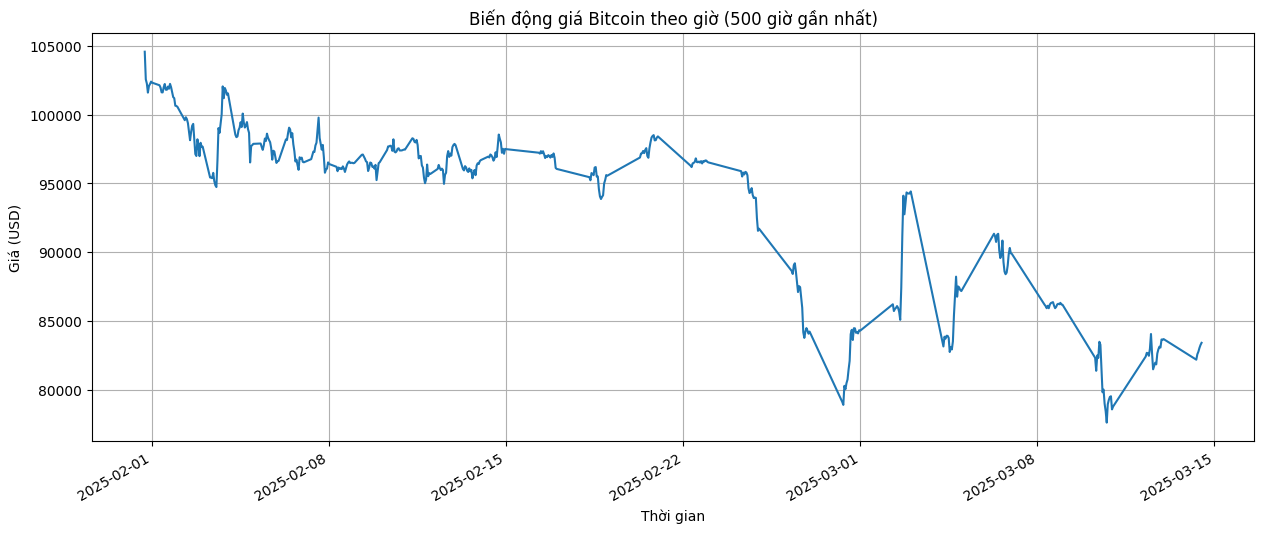

In [9]:
# Vẽ biểu đồ giá Bitcoin theo giờ (chỉ lấy 500 giờ gần nhất để dễ quan sát)
plt.figure(figsize=(15, 6))
df_hourly['Close'].tail(500).plot()
plt.title('Biến động giá Bitcoin theo giờ (500 giờ gần nhất)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

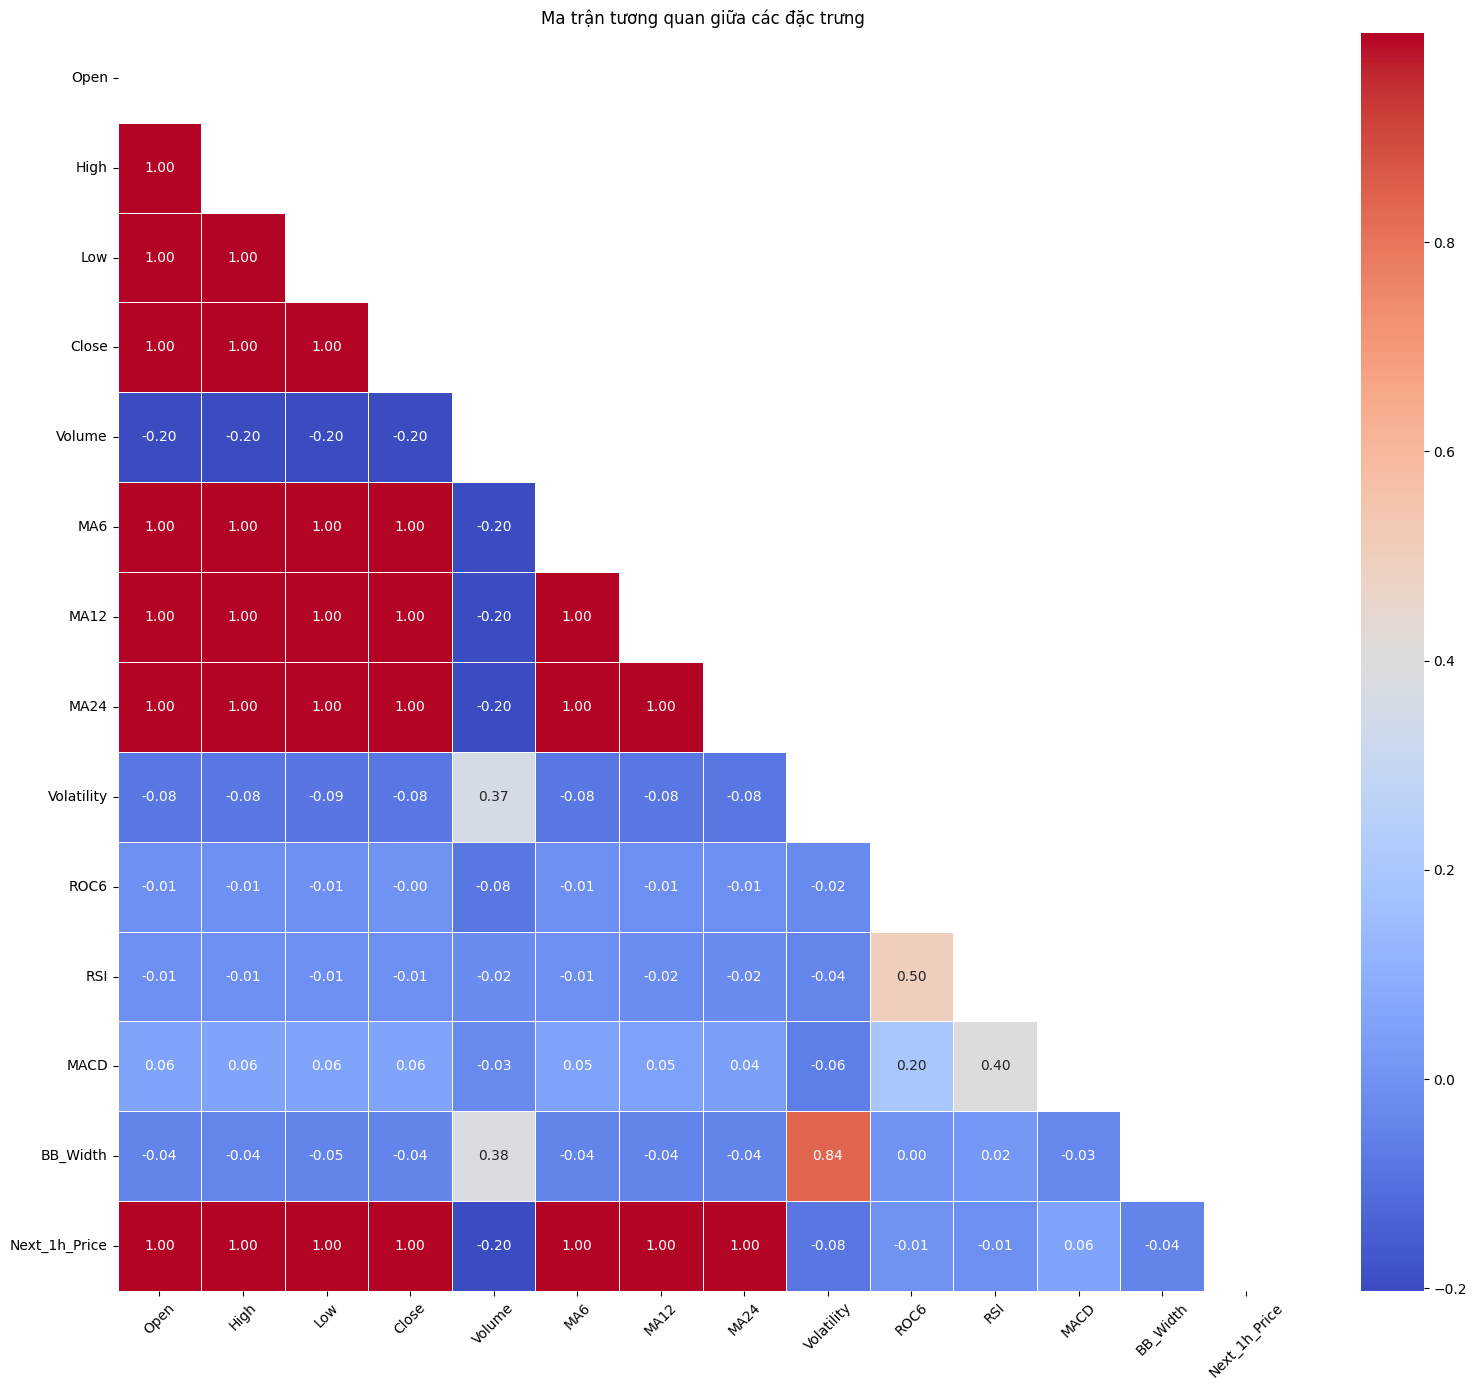

In [10]:
# Tạo ma trận tương quan
plt.figure(figsize=(16, 14))
# Chỉ chọn một số cột quan trọng để tránh ma trận quá lớn
correlation_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA6', 'MA12', 'MA24', 
                       'Volatility', 'ROC6', 'RSI', 'MACD', 'BB_Width', 'Next_1h_Price']
correlation = df_hourly[correlation_columns].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Chuẩn bị dữ liệu cho huấn luyện mô hình

In [11]:
# Chuẩn bị dữ liệu cho mô hình dự đoán giá cho giờ tiếp theo
target_column = 'Next_1h_Price'  # Dự đoán giá cho giờ tiếp theo

# Tách đặc trưng và biến mục tiêu
feature_columns = [col for col in df_hourly.columns if col not in ['Open', 'High', 'Low', 'Close', 'Hour', 'DayOfWeek'] + 
                   [f'Next_{i}h_Price' for i in range(1, 13)]]

X = df_hourly[feature_columns]
y = df_hourly[target_column]

In [12]:
# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Vì là dữ liệu chuỗi thời gian, chúng ta không xáo trộn dữ liệu
test_size = 0.2  # 20% dữ liệu cho kiểm tra
train_size = int(len(X_scaled) * (1 - test_size))

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

Kích thước tập huấn luyện: (90289, 20)
Kích thước tập kiểm tra: (22573, 20)


## 7. Huấn luyện và đánh giá các mô hình hồi quy

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test, scaler_y):
    """Đánh giá hiệu suất của một mô hình hồi quy"""
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Chuyển đổi về giá thực tế
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Tính toán các chỉ số đánh giá
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    # Tính độ lệch trung bình phần trăm tuyệt đối (MAPE)
    mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
    
    return {
        'model': model,
        'y_pred': y_pred,
        'y_pred_actual': y_pred_actual,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

In [14]:
# 1. Linear Regression (Lecture 3)
print("Huấn luyện mô hình Linear Regression...")
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, scaler_y)

print("\nKết quả đánh giá mô hình Linear Regression:")
print(f"RMSE: ${lr_results['rmse']:.2f}")
print(f"MAE: ${lr_results['mae']:.2f}")
print(f"R^2: {lr_results['r2']:.4f}")
print(f"MAPE: {lr_results['mape']:.4f}%")

Huấn luyện mô hình Linear Regression...

Kết quả đánh giá mô hình Linear Regression:
RMSE: $321.63
MAE: $157.52
R^2: 0.9998
MAPE: 0.3705%


In [15]:
# 2. Ridge Regression (Lecture 3)
print("\nHuấn luyện mô hình Ridge Regression...")
ridge_model = Ridge(alpha=1.0)  # alpha là tham số điều chỉnh độ phức tạp của mô hình
ridge_results = evaluate_model(ridge_model, X_train, X_test, y_train, y_test, scaler_y)

print("\nKết quả đánh giá mô hình Ridge Regression:")
print(f"RMSE: ${ridge_results['rmse']:.2f}")
print(f"MAE: ${ridge_results['mae']:.2f}")
print(f"R^2: {ridge_results['r2']:.4f}")
print(f"MAPE: {ridge_results['mape']:.4f}%")


Huấn luyện mô hình Ridge Regression...

Kết quả đánh giá mô hình Ridge Regression:
RMSE: $338.98
MAE: $170.83
R^2: 0.9998
MAPE: 0.3998%


In [16]:
# 3. Decision Tree Regression (Lecture 8)
print("\nHuấn luyện mô hình Decision Tree...")
dt_model = DecisionTreeRegressor(random_state=42)
dt_results = evaluate_model(dt_model, X_train, X_test, y_train, y_test, scaler_y)

print("\nKết quả đánh giá mô hình Decision Tree:")
print(f"RMSE: ${dt_results['rmse']:.2f}")
print(f"MAE: ${dt_results['mae']:.2f}")
print(f"R^2: {dt_results['r2']:.4f}")
print(f"MAPE: {dt_results['mape']:.4f}%")


Huấn luyện mô hình Decision Tree...

Kết quả đánh giá mô hình Decision Tree:
RMSE: $7371.42
MAE: $2365.37
R^2: 0.8869
MAPE: 3.5769%


In [17]:
# 4. Random Forest Regression (Lecture 8)
print("\nHuấn luyện mô hình Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, scaler_y)

print("\nKết quả đánh giá mô hình Random Forest:")
print(f"RMSE: ${rf_results['rmse']:.2f}")
print(f"MAE: ${rf_results['mae']:.2f}")
print(f"R^2: {rf_results['r2']:.4f}")
print(f"MAPE: {rf_results['mape']:.4f}%")


Huấn luyện mô hình Random Forest...

Kết quả đánh giá mô hình Random Forest:
RMSE: $7400.27
MAE: $2284.47
R^2: 0.8860
MAPE: 3.3339%


In [18]:
# 5. K-Nearest Neighbors Regression (Lecture 7)
print("\nHuấn luyện mô hình KNN Regression...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_results = evaluate_model(knn_model, X_train, X_test, y_train, y_test, scaler_y)

print("\nKết quả đánh giá mô hình KNN Regression:")
print(f"RMSE: ${knn_results['rmse']:.2f}")
print(f"MAE: ${knn_results['mae']:.2f}")
print(f"R^2: {knn_results['r2']:.4f}")
print(f"MAPE: {knn_results['mape']:.4f}%")


Huấn luyện mô hình KNN Regression...

Kết quả đánh giá mô hình KNN Regression:
RMSE: $8285.57
MAE: $4057.83
R^2: 0.8571
MAPE: 8.7585%


In [19]:
# 6. Support Vector Regression (Lecture 11)
print("\nHuấn luyện mô hình SVR...")
# SVR có thể chậm với dữ liệu lớn, nên chúng ta sẽ sử dụng kernel rbf với C=1.0
svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_results = evaluate_model(svr_model, X_train, X_test, y_train, y_test, scaler_y)

print("\nKết quả đánh giá mô hình SVR:")
print(f"RMSE: ${svr_results['rmse']:.2f}")
print(f"MAE: ${svr_results['mae']:.2f}")
print(f"R^2: {svr_results['r2']:.4f}")
print(f"MAPE: {svr_results['mape']:.4f}%")


Huấn luyện mô hình SVR...

Kết quả đánh giá mô hình SVR:
RMSE: $11978.55
MAE: $5660.74
R^2: 0.7012
MAPE: 9.8339%


## 8. So sánh và lựa chọn mô hình tốt nhất

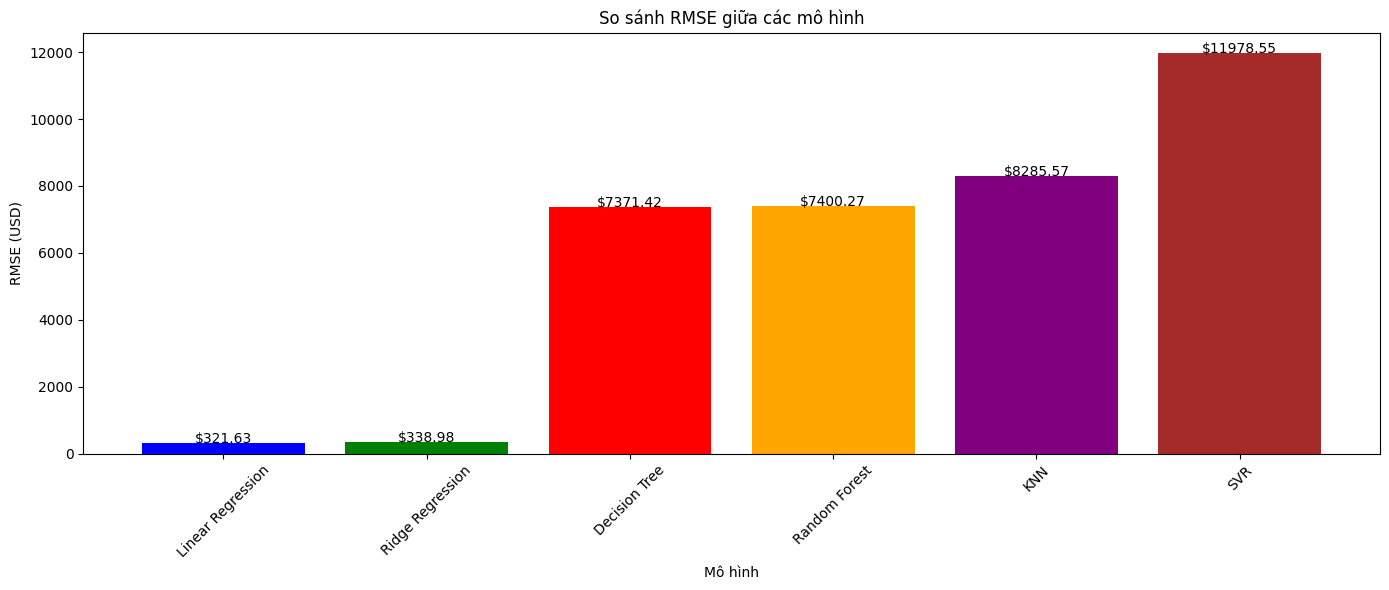

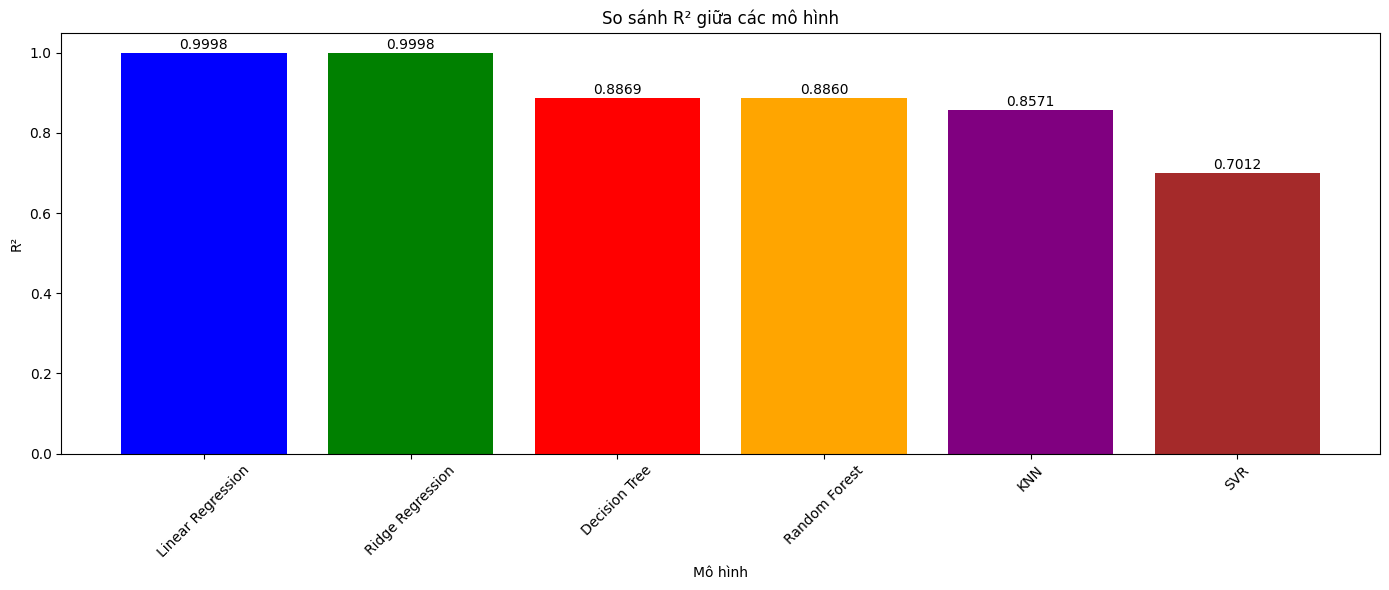

In [20]:
# So sánh hiệu suất của các mô hình
models = ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVR']
results = [lr_results, ridge_results, dt_results, rf_results, knn_results, svr_results]
rmse_values = [res['rmse'] for res in results]
r2_values = [res['r2'] for res in results]
mape_values = [res['mape'] for res in results]

# Tạo biểu đồ so sánh RMSE
plt.figure(figsize=(14, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'red', 'orange', 'purple', 'brown'])
plt.title('So sánh RMSE giữa các mô hình')
plt.xlabel('Mô hình')
plt.ylabel('RMSE (USD)')
plt.xticks(rotation=45)
for i, v in enumerate(rmse_values):
    plt.text(i, v + 5, f'${v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# Tạo biểu đồ so sánh R^2
plt.figure(figsize=(14, 6))
plt.bar(models, r2_values, color=['blue', 'green', 'red', 'orange', 'purple', 'brown'])
plt.title('So sánh R² giữa các mô hình')
plt.xlabel('Mô hình')
plt.ylabel('R²')
plt.xticks(rotation=45)
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [21]:
# Xác định mô hình tốt nhất dựa trên RMSE (giá trị càng thấp càng tốt)
best_model_index = np.argmin(rmse_values)
best_model_name = models[best_model_index]
best_model = results[best_model_index]['model']
best_results = results[best_model_index]

print(f"\nMô hình có hiệu suất tốt nhất dựa trên RMSE: {best_model_name}")
print(f"RMSE: ${best_results['rmse']:.2f}")
print(f"R^2: {best_results['r2']:.4f}")
print(f"MAPE: {best_results['mape']:.4f}%")


Mô hình có hiệu suất tốt nhất dựa trên RMSE: Linear Regression
RMSE: $321.63
R^2: 0.9998
MAPE: 0.3705%


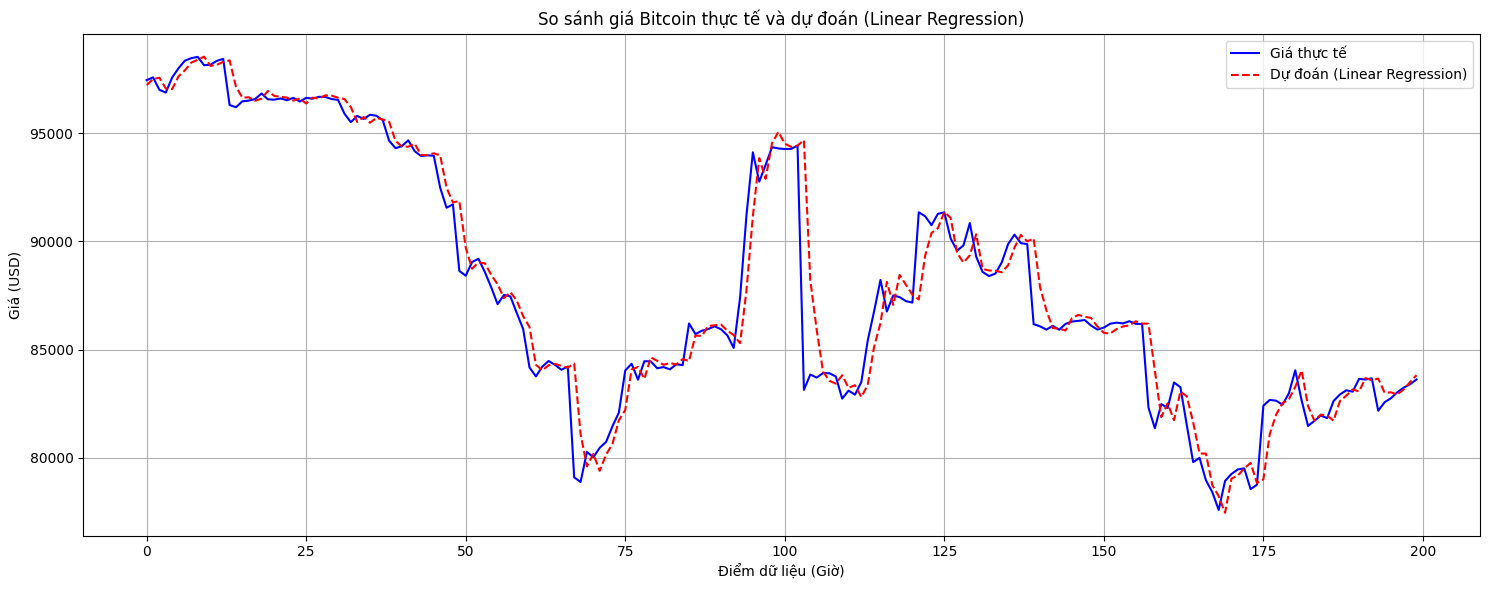

In [22]:
# Trực quan hóa kết quả dự đoán của mô hình tốt nhất
plt.figure(figsize=(15, 6))

# Lấy giá thực tế từ tập kiểm tra
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Chỉ hiển thị 200 điểm dữ liệu cuối để biểu đồ dễ đọc
display_points = 200
plt.plot(y_test_actual[-display_points:], label='Giá thực tế', color='blue')
plt.plot(best_results['y_pred_actual'][-display_points:], label=f'Dự đoán ({best_model_name})', 
         color='red', linestyle='--')

plt.title(f'So sánh giá Bitcoin thực tế và dự đoán ({best_model_name})')
plt.xlabel('Điểm dữ liệu (Giờ)')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Tối ưu hóa siêu tham số cho mô hình tốt nhất

In [23]:
# Tối ưu hóa siêu tham số dựa trên loại mô hình tốt nhất
if best_model_name == "Random Forest":
    print("\nĐang tối ưu hóa siêu tham số cho Random Forest...")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
elif best_model_name == "KNN":
    print("\nĐang tối ưu hóa siêu tham số cho KNN...")
    
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # p=1 cho khoảng cách Manhattan, p=2 cho khoảng cách Euclidean
    }
    
    grid_search = GridSearchCV(
        KNeighborsRegressor(), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
elif best_model_name == "Decision Tree":
    print("\nĐang tối ưu hóa siêu tham số cho Decision Tree...")
    
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
    }
    
    grid_search = GridSearchCV(
        DecisionTreeRegressor(random_state=42), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
elif best_model_name == "SVR":
    print("\nĐang tối ưu hóa siêu tham số cho SVR...")
    
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }
    
    grid_search = GridSearchCV(
        SVR(), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
elif best_model_name == "Ridge Regression":
    print("\nĐang tối ưu hóa siêu tham số cho Ridge Regression...")
    
    param_grid = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
    
    grid_search = GridSearchCV(
        Ridge(), 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

if best_model_name in ["Random Forest", "KNN", "Decision Tree", "SVR", "Ridge Regression"]:
    # Huấn luyện GridSearchCV
    grid_search.fit(X_train, y_train)
    
    print(f"\nSiêu tham số tốt nhất: {grid_search.best_params_}")
    
    # Huấn luyện mô hình với siêu tham số tốt nhất
    best_model = grid_search.best_estimator_
    
    # Đánh giá mô hình tối ưu
    optimized_results = evaluate_model(best_model, X_train, X_test, y_train, y_test, scaler_y)
    
    print("\nKết quả đánh giá mô hình tối ưu:")
    print(f"RMSE: ${optimized_results['rmse']:.2f}")
    print(f"MAE: ${optimized_results['mae']:.2f}")
    print(f"R^2: {optimized_results['r2']:.4f}")
    print(f"MAPE: {optimized_results['mape']:.4f}%")
    
    # Cập nhật best_results
    best_results = optimized_results
    
    # Phân tích tầm quan trọng của đặc trưng nếu là mô hình Random Forest hoặc Decision Tree
    if best_model_name in ["Random Forest", "Decision Tree"]:
        feature_importance = pd.DataFrame({
            'Đặc trưng': X.columns,
            'Tầm quan trọng': best_model.feature_importances_
        }).sort_values('Tầm quan trọng', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Tầm quan trọng', y='Đặc trưng', data=feature_importance.head(15))
        plt.title('15 đặc trưng quan trọng nhất trong dự đoán giá Bitcoin')
        plt.tight_layout()
        plt.show()

## 10. Dự đoán giá Bitcoin cho 12 giờ tới

In [24]:
def predict_next_hours(model, last_data, scaler_x, scaler_y, hours=12):
    """Dự đoán giá Bitcoin cho một số giờ tiếp theo"""
    forecasted_prices = []
    
    # Lấy dữ liệu mới nhất
    current_data = last_data.copy()
    
    for _ in range(hours):
        # Dự đoán giá cho giờ tiếp theo
        prediction_scaled = model.predict(current_data.reshape(1, -1))[0]
        
        # Chuyển đổi về giá thực tế
        prediction = scaler_y.inverse_transform([[prediction_scaled]])[0][0]
        forecasted_prices.append(prediction)
        
        # Thêm một biến động nhỏ vào dữ liệu để tránh dự đoán giống nhau
        noise = np.random.normal(0, 0.01, current_data.shape)
        current_data = current_data * (1 + noise)
        
    return forecasted_prices

In [25]:
# Lấy dữ liệu mới nhất để dự đoán
last_data = X_scaled[-1]

# Dự đoán giá cho 12 giờ tới
future_prices = predict_next_hours(best_model, last_data, scaler_X, scaler_y, hours=12)

# Tạo dãy thời gian cho dự báo
last_time = df_hourly.index[-1]
future_times = [last_time + dt.timedelta(hours=i+1) for i in range(12)]

# Hiển thị kết quả dự báo
print("\nDự đoán giá Bitcoin trong 12 giờ tới:")
for time, price in zip(future_times, future_prices):
    print(f"{time.strftime('%Y-%m-%d %H:%M')}: ${price:.2f}")


Dự đoán giá Bitcoin trong 12 giờ tới:
2025-03-14 13:00: $83822.75
2025-03-14 14:00: $86056.89
2025-03-14 15:00: $85042.14
2025-03-14 16:00: $83866.75
2025-03-14 17:00: $84155.31
2025-03-14 18:00: $85740.57
2025-03-14 19:00: $88101.45
2025-03-14 20:00: $88639.49
2025-03-14 21:00: $88544.74
2025-03-14 22:00: $88095.17
2025-03-14 23:00: $90984.11
2025-03-15 00:00: $90284.05


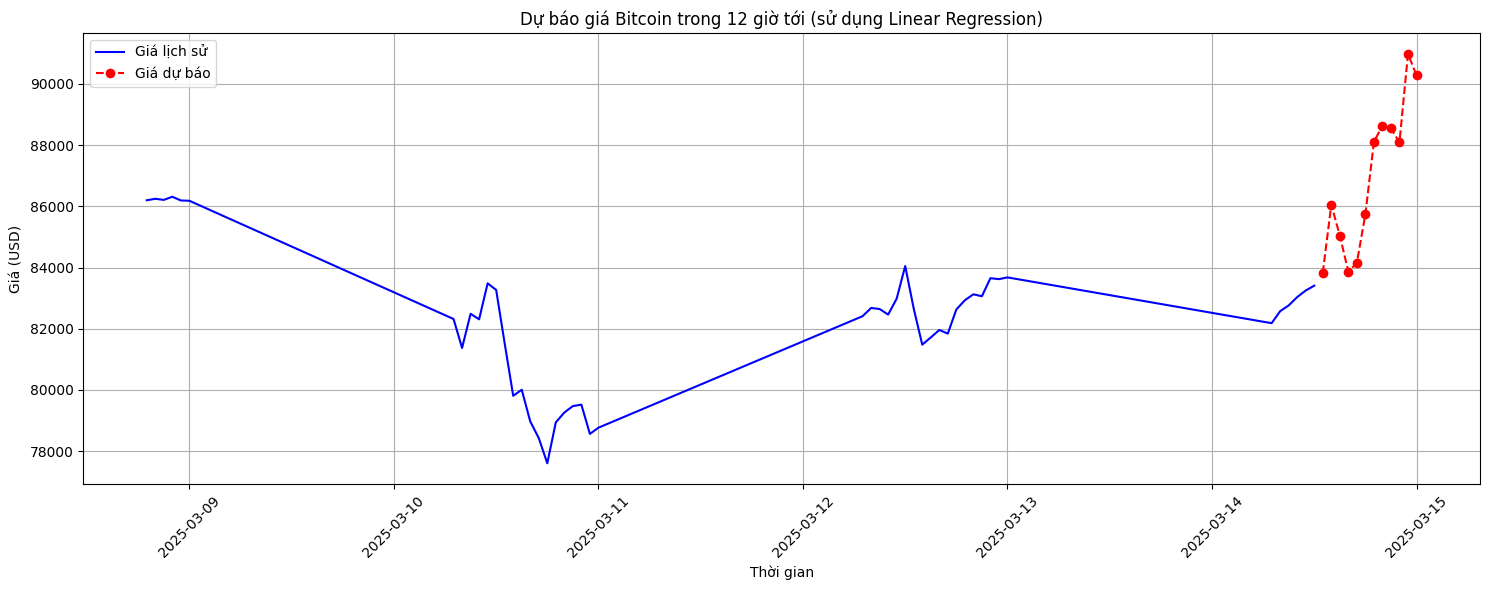

In [26]:
# Trực quan hóa dự báo trong 12 giờ tới
plt.figure(figsize=(15, 6))

# Lấy dữ liệu lịch sử để vẽ biểu đồ
historical_times = df_hourly.index[-48:]  # 48 giờ cuối
historical_prices = df_hourly['Close'].iloc[-48:].values

# Vẽ dữ liệu lịch sử và dự báo
plt.plot(historical_times, historical_prices, 'b-', label='Giá lịch sử')
plt.plot(future_times, future_prices, 'r--', marker='o', label='Giá dự báo')

plt.title(f'Dự báo giá Bitcoin trong 12 giờ tới (sử dụng {best_model_name})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Kết luận

In [27]:
print("\n=== Kết luận ===")
print(f"Mô hình {best_model_name} đã được chọn là mô hình tốt nhất cho dự đoán giá Bitcoin theo giờ.")
print(f"RMSE của mô hình: ${best_results['rmse']:.2f}")
print(f"R² của mô hình: {best_results['r2']:.4f}")
print(f"MAPE của mô hình: {best_results['mape']:.4f}%")

print("\nSo sánh các mô hình từ slide môn học:")
print("1. Linear Regression (Lecture 3): Mô hình đơn giản, dễ hiểu, nhưng khả năng nắm bắt mối quan hệ phi tuyến hạn chế")
print("2. Ridge Regression (Lecture 3): Cải thiện Linear Regression bằng cách ngăn overfitting")
print("3. Decision Tree (Lecture 8): Mô hình trực quan, dễ hiểu, nhưng dễ overfitting")
print("4. Random Forest (Lecture 8): Kết hợp nhiều cây quyết định, giảm overfitting, thường cho kết quả tốt")
print("5. KNN (Lecture 7): Đơn giản, hiệu quả cho dữ liệu có cấu trúc không gian")
print("6. SVR (Lecture 11): Mạnh mẽ với dữ liệu phức tạp, nhưng chậm với dữ liệu lớn")

print("\nĐặc điểm quan trọng của dự đoán:")
print("1. Dự đoán giá Bitcoin theo giờ thay vì theo ngày giúp nắm bắt tốt hơn biến động ngắn hạn")
print("2. Các chỉ báo kỹ thuật cung cấp thông tin quan trọng để dự đoán sự biến động của giá")

if best_model_name in ["Random Forest", "Decision Tree"]:
    print(f"3. Đặc trưng quan trọng nhất theo {best_model_name} là: {feature_importance['Đặc trưng'].iloc[0]}")

print("\nNhận xét về kết quả dự đoán:")
if best_results['r2'] > 0.7:
    print("Mô hình có khả năng dự đoán tốt dựa trên chỉ số R².")
elif best_results['r2'] > 0.5:
    print("Mô hình có khả năng dự đoán ở mức trung bình dựa trên chỉ số R².")
else:
    print("Mô hình có khả năng dự đoán thấp, cần cải thiện thêm.")

print("\nLưu ý quan trọng: Thị trường tiền điện tử rất biến động và chịu ảnh hưởng của nhiều yếu tố không lường trước được.")
print("Dự đoán này chỉ nên được sử dụng như một tham khảo, không nên dùng làm cơ sở duy nhất cho quyết định đầu tư.") 


=== Kết luận ===
Mô hình Linear Regression đã được chọn là mô hình tốt nhất cho dự đoán giá Bitcoin theo giờ.
RMSE của mô hình: $321.63
R² của mô hình: 0.9998
MAPE của mô hình: 0.3705%

So sánh các mô hình từ slide môn học:
1. Linear Regression (Lecture 3): Mô hình đơn giản, dễ hiểu, nhưng khả năng nắm bắt mối quan hệ phi tuyến hạn chế
2. Ridge Regression (Lecture 3): Cải thiện Linear Regression bằng cách ngăn overfitting
3. Decision Tree (Lecture 8): Mô hình trực quan, dễ hiểu, nhưng dễ overfitting
4. Random Forest (Lecture 8): Kết hợp nhiều cây quyết định, giảm overfitting, thường cho kết quả tốt
5. KNN (Lecture 7): Đơn giản, hiệu quả cho dữ liệu có cấu trúc không gian
6. SVR (Lecture 11): Mạnh mẽ với dữ liệu phức tạp, nhưng chậm với dữ liệu lớn

Đặc điểm quan trọng của dự đoán:
1. Dự đoán giá Bitcoin theo giờ thay vì theo ngày giúp nắm bắt tốt hơn biến động ngắn hạn
2. Các chỉ báo kỹ thuật cung cấp thông tin quan trọng để dự đoán sự biến động của giá

Nhận xét về kết quả dự đoán:
M

In [28]:
# # Dự đoán giá Bitcoin theo giờ
# Nhập môn Học máy và Khai phá dữ liệu (IT3190)